# Proteína CDK2

### Obtención de los ligandos ubicados en la cavidad de la proteína
Esta libreta tiene como objetivo obtener los ligandos cocristalizados en el sitio activo de la proteína CDK2, difereciando dichas moléculas de iones, moléculas del solvente, o residuo modeificados de la proteína. Y diferenciando también entre posibles inhibidores alostéricos de inhibidores competitivos.

## En resumen:
Se realizan los siguientes pasos:

1. Se identifican los residuos que forman parte del pocket de interés de la proteína (en este caso el sitio activo de la ERK2), tomando una estructura cristalográfica de referencia.
2. Se itera la lista de archivos pdb de la proteína evaluando todas las posibles moléculascon átomos con la etiqueta HETATM que puedan ser ligandos. Para ello:
     - Se evalúa que la molécula esté en la cavidad de interés de la proteína.
     - Se evalúa qeu la molécula tenga como mínimo un peso molecular para diferenciarla de iones o moléculas del solvente.
     - Se evalúa que la molécula no forme parte de la cadena protéica, es decir, que no sea un residuo no estándar de la proteína.
3. Si los criterios anteriores se cumplen, se guarda la molécula en nuevo archivo pdb.

#### Importamos parte de las librerías a usar


In [1]:
from prody import *
import numpy as np
import csv
import pandas as pd

In [2]:
# Nombre de la proteina de interés
prot_name = 'cdk2'

#### Carga del dataframe con la información de la proteína

In [16]:
# abrir la tabla de metadatos de las proteinas
import glob, os
# Directorio hacia el archivo csv
path_df_csv = glob.glob(os.path.join('.', 'data', 
                        F'TABLA_MTDATA_{prot_name.upper()}_*_crys.json'))
df_prot = pd.read_json(path_df_csv[0])
df_prot.set_index('PDB_ID', inplace=True)
df_prot.tail(3)

,Title,Date,Entities,ChainID,Resolution,Identity,Coverage,NumGaps,GapLen,GapPos,NumLigs,NameLigs
PDB_ID,,,,,,,,,,,,
6q4i,cdk2 in complex with fraglite35,2019-03-20,1,A,1.11,297,96.644295,2,"[8, 4]","[[38, 45], [153, 156]]",2,"[DMS, HGK]"
6q4j,cdk2 in complex with fraglite34,2019-03-20,1,A,1.05,298,96.979866,2,"[9, 3]","[[39, 47], [155, 157]]",2,"[DMS, HHB]"
6q4k,cdk2 in complex with fraglite38,2019-03-20,1,A,1.06,298,97.651007,2,"[8, 2]","[[39, 46], [125, 126]]",2,"[EDO, HHW]"


In [17]:
df_prot.shape

(402, 12)

### Conteo de estructuras con ligandos
Preguntamos cuántas y cuales estructuras cristalográficas tienen ligandos y creamos una nueva tabla con ellas (df_prot_ligs).

In [18]:
df_prot_ligs = df_prot[df_prot.NumLigs > 0]
print(F'{len(df_prot_ligs)} de {len(df_prot)} cristales con al menos un ligando.')

395 de 402 cristales con al menos un ligando.


### Nota:
> **No todas estas moléculas son ligandos de la proteína**, ya que sólo hemos identificado cadenas en el archivo pdb con la designación HETATM; pudiendo ser iones, residuos no éstandar (con modificaciones postraduccionales) o moléculas del cosolvente usado durante obtención de la estructura.
Por lo tanto, si es ligando o no lo determinamos más adelante.

### ¿Cuántos ligandos diferentes hay?
Ahora preguntamos cuántas moléculas distintas han sido co-cristalizadas con la proteína.

In [20]:
# ¿Cuantos ligandos hay en total?
import itertools
# Lista de nombre de todos los ligandos
lig_full_list = list( itertools.chain.from_iterable( df_prot.NameLigs ) )
print(F'En total hay {len(lig_full_list)} moléculas HETATM,')

lig_all_list = list(set(lig_full_list))
print(F'de las cuales {len(lig_all_list)} son moléculas DISTINTAS.')

En total hay 759 moléculas HETATM,
de las cuales 365 son moléculas DISTINTAS.


## Moléculas en la cavidad catalítica
Ahora procedemos a identificar qué moléculas se encuentran en el sitio activo de la proteína, y si éstas tienen un peso molecular suficcientemente grande como para ser diferenciadas de posibles moléculas del solvente.

In [24]:
from modules.subsecuencias_cdk2 import get_pocket_residues
pocket_residues = get_pocket_residues('str')
print(len(get_pocket_residues('list')), "residuos corresponden a los que definen al pocket de la proteína CDK2.")
print(pocket_residues)

40 residuos corresponden a los que definen al pocket de la proteína CDK2.
8 9 10 11 12 13 14 15 16 17 18 19 30 31 32 33 64 65 79 80 81 82 83 84 85 86 87 88 89 90 129 130 131 132 133 134 143 144 145 146


### Carga de una estructura de referencia

In [29]:
# Estructura de referencia con hidrógenos, la obtenemos del ensamble
pdbs_model_dir = "../ARCHIVOS/CRISTALES/PROT_CDK2_PREPARADAS/PREP_ALL_ENSAMBLE/"
ref_id = '1fin'
pdb_file_tail = "_ENS.pdb"
# Cargamos el archivo de referencia
ref_structure = parsePDB(pdbs_model_dir + ref_id + pdb_file_tail)
ref_structure.setChids("A")

@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.


### Visualización del sitio activo

In [28]:
# Cálculo del centro total de la proteína de referencia
centro_strc_total = calcCenter(ref_structure).round(3)
# Definimos los átomos del pocket
pocket = ref_structure.select("ca resnum " + pocket_residues)
centro_pocket = calcCenter(pocket)
print("Centro de la estructura completa:", centro_strc_total)
print("Centro de los Ca del sitio activo:", centro_pocket)

Centro de la estructura completa: [-20.114 214.997 119.258]
Centro de los Ca del sitio activo: [-12.5263   206.416975 113.78675 ]


In [32]:
# Seleccionamos todos los átomos de los residuos en selected_residues
pocket_atoms = ref_structure.select(F'resnum {pocket_residues}')
# Obtenemos los índices de los átomos
pocket_atoms_index = pocket_atoms.getIndices()

In [35]:
import nglview as nv
view = nv.show_prody(ref_structure)
view.clear_representations()
view.add_representation('cartoon', selection='protein', color='white')
view.add_licorice(selection = pocket_atoms_index, color='red')
view.add_cartoon(selection = pocket_atoms_index, color='red')
view

NGLWidget()

In [ ]:
view.render_image()

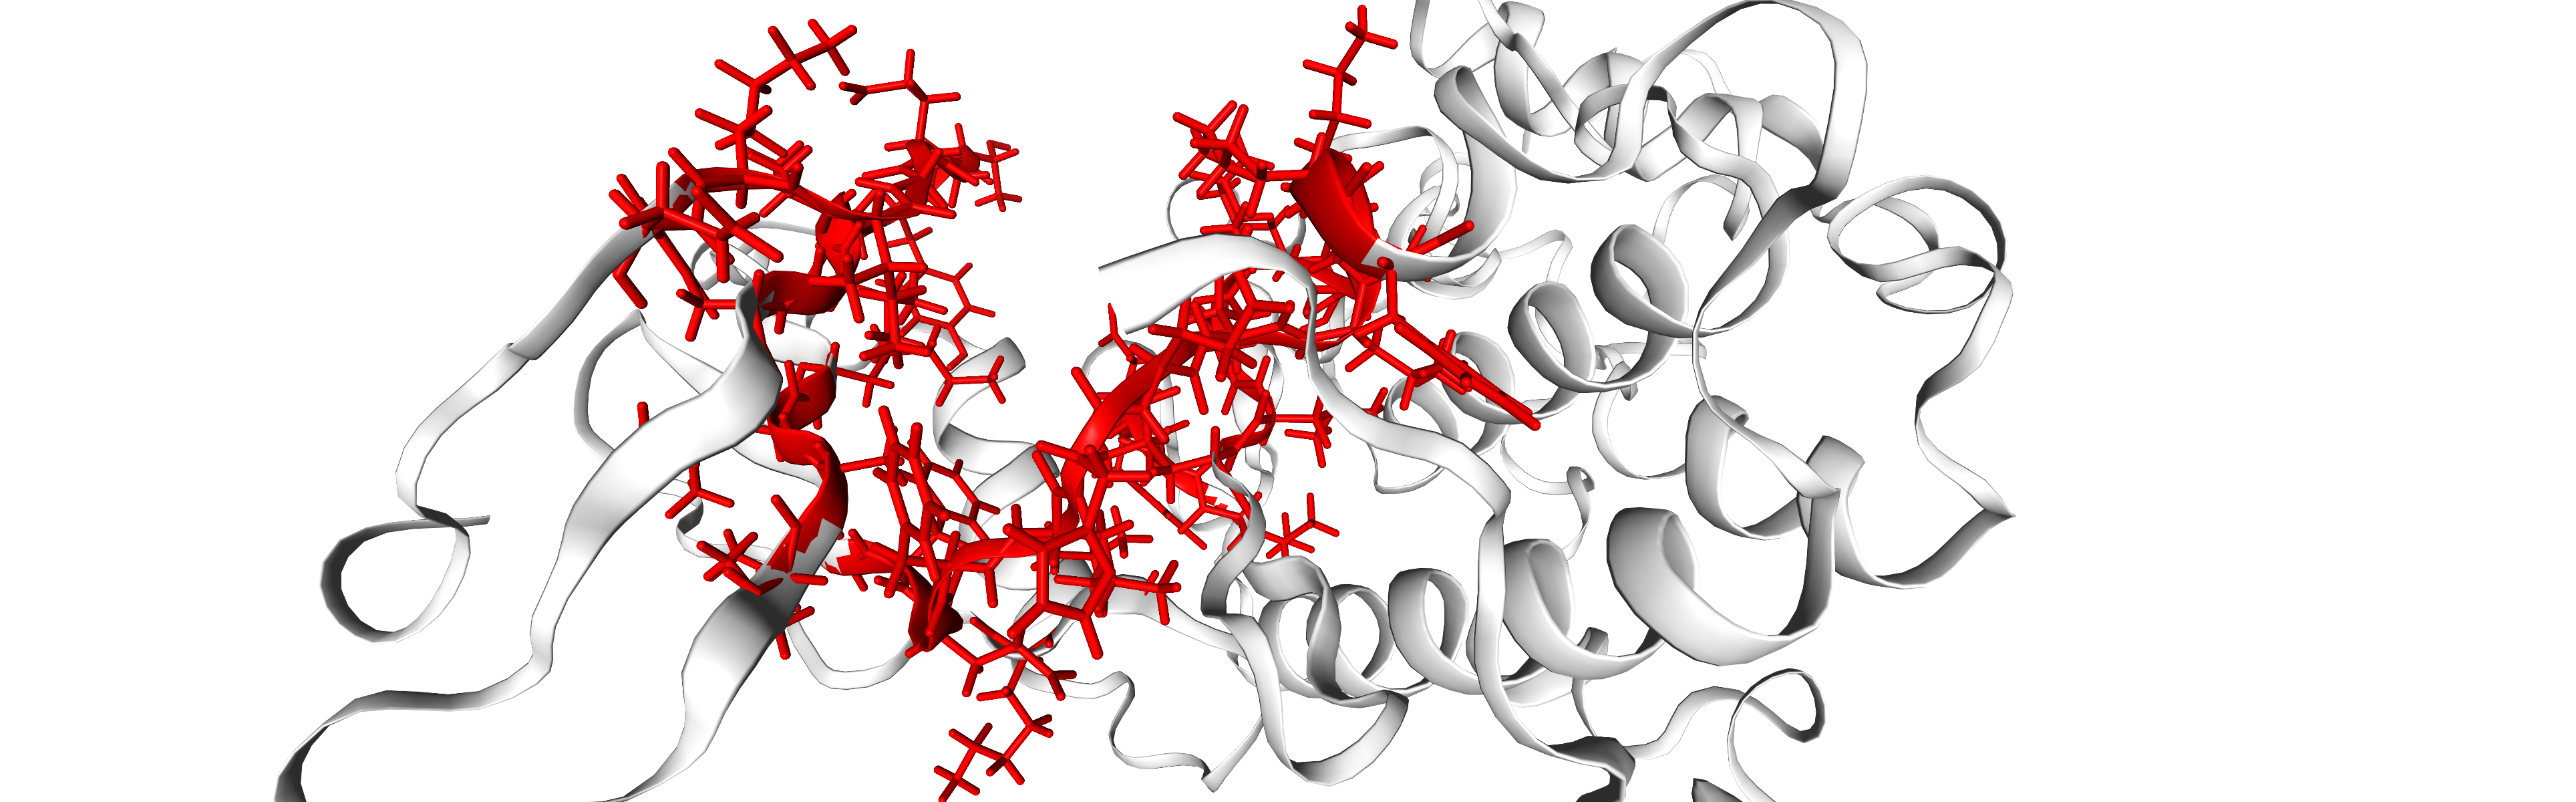

In [37]:
view._display_image()

## Determinación de los ligandos
Ahora, procedemos a utilizar la estructura de referencia modelada con Modeller. Hay que recordar que todas las estructuras modeladas fueron alineadas previamente tomando en cuenta la estructura secundaria de la proteína, y que el alineamiento incluyó la reposición relativa de los ligandos.

In [29]:
def get_pocket_ligand(pdb_id, ref_structure,
                         PROT_DIR_in = pdbs_model_dir, 
                         RAW_LIG_DIR= "../ARCHIVOS/CRISTALES/LIGS_CDK2/RAW/",
                         #PROT_DIR_out = "../PDB_CDK2_DOCKING/CDK2_PROT_ALIGNED",
                         PREP_LIG_DIR_out= "../ARCHIVOS/CRISTALES/LIGS_CDK2/IN_POCKET_NON_PREP/",
                         zona = 2.0, tail_file_pdb_prot = "_ENS.pdb",
                         pocket_residues = get_ricci_residues(),
                         write_files = True):

    # Se carga el ligando en CRUDO usando Prody
    try:
        lig = parsePDB(RAW_LIG_DIR + "/" + pdb_id  + "_lig.pdb")
        # print("Número de ligandos", len( np.unique(lig.getResnums() )) )
    except Exception as e:
        print(e, "La proteina", pdb_id, "NO TIENE LIGANDO.")
        return(None, None)

    # Se carga la proteína usando los residuos que definen el pocket de la proteína
    protein = parsePDB(PROT_DIR_in + "/" + pdb_id + tail_file_pdb_prot)
    protein_pocket = protein.select("resid " + pocket_residues)

    # Se seleccionan los ligandos (RESIDUOS no protéicos) que estén a no más de X A
    # de cualquier átomo de los residuos del pocket de la proteína
    lig_sel = lig.select('within ' + str(zona) + ' of inhibitor', inhibitor = protein_pocket)
    if lig_sel is None:
        print("La proteina", pdb_id, "no tiene ligando en el pocket.")
        return(None, None)

    # Se obtine la lista de moléculas que cumplen el criterio anterior
    inhibidor_list = np.unique( lig_sel.getResnums() )
    print(lig_sel.getResnums())
    
    # Calcula los centros geométricos de cada molécula
    prot_pocket_center = calcCenter(protein_pocket).round(3)
    
    # Puede que haya más de una molécula en el pocket (debido a presencia de iones o moléculas pequeñas)
    # Se itera entre cada molecula del ligando, se calcula su masa y se mantiene el ligando con mayor masa 
    masa_lig = 1
    final_lig = ""

    for i in inhibidor_list:
            mol = lig.select("resnum " + str(i))
            masa = mol.getMasses().sum()
            print(masa)
            if masa == masa_lig:
                dist_prot_m1 = calcDistance(prot_pocket_center, calcCenter(mol))
                dist_prot_m2 = calcDistance(prot_pocket_center, calcCenter(final_lig))
                if dist_prot_m1 < dist_prot_m2:
                    masa_lig, final_lig = masa, mol
                    continue
            masa_lig, final_lig = (masa, mol) if masa > masa_lig else (masa_lig, final_lig)
            
    # Se extrae el nombre del ligando
    name_lig = np.unique( final_lig.getResnames() )[0]
    # print(name_lig, " es el ligando, con una masa de ", masa_lig)
    
    # Se combinan proteína y ligando en una sola instancia, de tal manera que
    # sea posible superponer las estructuras de la proteína de acuerdo a los residuos de su pocket
    # y esto afcete la psoición del ligando
    complejo_PL = protein + final_lig.toAtomGroup()

    # Se hace el alineamiento con los residuos de Pisani y la estructura de referencia
    # matchAlign(complejo_PL, ref_structure, tarsel= "ca resnum " + ricci_residues())

    # Se guarda el ligando sólo si su masa es igual o mayor a la de una molécula de benceno: 78,11
    # si el ligando aparece 2 veces cerca del pocket, se elige la molécula más cercana al
    # centro geométrico del pocket
    if final_lig.getMasses().sum() >= 70:
        if write_files:
            # Se guardan ligando y proteína alineados según la estructura de referencia
            # Ligando
            writePDB( PREP_LIG_DIR_out+ "/" + pdb_id + "_" + name_lig + "_LIG.pdb", 
                     complejo_PL.select("resname " + name_lig) )
            
           # writePDB( PROT_DIR_out + "/" + pdb_id + "_" + name_lig + "_PROT.pdb", 
           #          complejo_PL.select("protein") )
        return(name_lig, masa_lig)
    
    else: 
        print("La proteina", pdb_id, "NO TIENE LIGANDO (masa => 80.0).")
        return(None, None)

In [30]:
# Se obtienen los ligandos y a la tabla de datos se le agrega la información sobre el inhibidor y su masa

df_cdk2_c = df_cdk2.copy()
# Se agregan dos columnas
df_cdk2_c["Inhib"] = ""
df_cdk2_c["Inhib_mass"] = np.nan
# Se establecen los PDB IDs  como indices
df_cdk2_c = df_cdk2_c.set_index("PDB_ID")

pdb_id_prueba = ["3pxf"]

# Se obtienen los ligandos
for pdb_id in df_cdk2_c.index:
    inhibidor = get_pocket_ligand(pdb_id, write_files=True, 
                                  ref_structure=ref_structure, zona=3.0)
    df_cdk2_c.at[str(pdb_id), 'Inhib'] = inhibidor[0]
    df_cdk2_c.at[pdb_id, 'Inhib_mass'] = inhibidor[1]
    
df_cdk2_c = df_cdk2_c.reset_index()

@> 35 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.17s.
@> 35 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.08s.
@> 35 atoms and 1 coordinate set(s) were parsed in 0.00s.


[299 299 299 299 299 299 299 299 299 299 299 299 299 299 299 299 299]
440.0
[382 381 381 381 381 381 381 381 381 381 381 381 381 381 381 381 381 381
 381 381 381 381 381 381]
398.0
0.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.08s.
@> 22 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> 22 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.07s.


[382 381 381 381 381 381 381 381 381 381 381 381 381 381 381 381 381 381
 381 381 381 381 381 381]
398.0
0.0
../ARCHIVOS/CRISTALES/LIGS_CDK2/RAW//1buh_lig.pdb is not a valid filename or a valid PDB identifier. La proteina 1buh NO TIENE LIGANDO.
[299 299 299 299 299 299 299 299 299 299 299 299 300 300 300]
214.0
56.0
[500 500 500 500 500 500 500 500 500 500 500 500 500 500 500]
282.0


@> 35 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 21 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 21 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> 24 atoms and 1 coordinate set(s) were parsed in 0.00s.


[400 400 400 400 400 400 400 400 400 400 400 400 401 401 401]
234.0
56.0
[401 401 401 401 401 401 401 401 401 401 401]
230.0
[401 401 401 401 401 401 401 401 401 401 401]
234.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 1 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 31 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 32 atoms and 1 coordinate set(s) were parsed in 0.00s.


[1298 1298 1298 1298 1298 1298 1298 1298 1298 1298 1298 1298 1298 1298
 1298 1298 1298 1298 1298]
332.0
La proteina 1f5q no tiene ligando en el pocket.
[299 299 299 299 299 299 299 299 299 299 299]
398.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> 23 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 31 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 30 atoms and 1 coordinate set(s) were parsed in 0.00s.


[383 381 381 381 381 381 381 381 381 381 381 381 381 381 381 381]
398.0
0.0
[299 299 299 299 299 299 299 299 299 299 299 299]
304.0
[501 501 501 501 501 501 501 501 501 501 501 501 501 501 501 501 501 501
 501]
434.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> 23 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 23 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 27 atoms and 1 coordinate set(s) were parsed in 0.00s.


[400 400 400 400 400 400 400 400 400 400 400 400 400 400 400]
374.0
[501 501 501 501 501 501 501 501 501 501 501 501 501 501]
292.0
[501 501 501 501 501 501 501 501 501 501 501 501 501]
292.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.08s.
@> 32 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 25 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 33 atoms and 1 coordinate set(s) were parsed in 0.00s.


[501 501 501 501 501 501 501 501 501 501 501 501 501 501 501]
344.0
[1297 1297 1297 1297 1297 1297 1297 1297 1297 1297 1297 1297 1297 1297
 1297 1297 1298 1299 1299 1299]
350.0
0.0
62.0
[1300 1300 1300 1300 1300 1300 1300 1300 1300 1300 1300 1300 1300 1300]
222.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> 54 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 36 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 38 atoms and 1 coordinate set(s) were parsed in 0.00s.


[1300 1300 1300 1300 1300 1300 1300 1300 1300 1300 1300 1300 1300 1300
 1300 1300 1300 1300]
354.0
[ 33  33  33  33  33  33  33  33  33 299 299 299 299 300 300 300 300 301
 301 301 301 301 301 301 301 301 301 301]
160.0
84.0
84.0
354.0
[301 301 301 301 301 301 301 301 301 301 301 301 301 301 301 301 301]
404.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.09s.
@> 18 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> 18 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 18 atoms and 1 coordinate set(s) were parsed in 0.00s.


[299 299 299 299 299 299 299 299 299 299 299 299 299 299 299 299 299 299
 299]
354.0
[1299 1299 1299 1299 1299 1299 1299 1299 1299 1299]
236.0
[1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299]
228.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 24 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 25 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.07s.


[1298 1298 1298 1298 1298 1298]
230.0
[1298 1298 1298 1298 1298 1298 1298 1298 1298 1298 1298 1298 1298 1298
 1298 1298]
302.0
[1298 1298 1298 1298 1298 1298 1298 1298 1298 1298 1298]
302.0


@> 28 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 1 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> 1 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 32 atoms and 1 coordinate set(s) were parsed in 0.00s.


[1298 1298 1298 1298 1298 1298 1298 1298 1298 1298 1298 1298 1298 1298]
380.0
../ARCHIVOS/CRISTALES/LIGS_CDK2/RAW//1h24_lig.pdb is not a valid filename or a valid PDB identifier. La proteina 1h24 NO TIENE LIGANDO.
../ARCHIVOS/CRISTALES/LIGS_CDK2/RAW//1h25_lig.pdb is not a valid filename or a valid PDB identifier. La proteina 1h25 NO TIENE LIGANDO.
La proteina 1h26 no tiene ligando en el pocket.
[297]
14.0
La proteina 1h27 NO TIENE LIGANDO (masa => 80.0).
../ARCHIVOS/CRISTALES/LIGS_CDK2/RAW//1h28_lig.pdb is not a valid filename or a valid PDB identifier. La proteina 1h28 NO TIENE LIGANDO.


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 32 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 19 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 23 atoms and 1 coordinate set(s) were parsed in 0.00s.


[401 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400
 400 400 400 400 400 400 400]
398.0
0.0
../ARCHIVOS/CRISTALES/LIGS_CDK2/RAW//1hcl_lig.pdb is not a valid filename or a valid PDB identifier. La proteina 1hcl NO TIENE LIGANDO.
[299 300 300 300 300 300 300 300 300 300 300 300 300 300 300 300 300 300
 300 300 300]
0.0
398.0
[400 400 400 400 400 400 400 400 400 400 400]
254.0
../ARCHIVOS/CRISTALES/LIGS_CDK2/RAW//1jvp_lig.pdb is not a valid filename or a valid PDB identifier. La proteina 1jvp NO TIENE LIGANDO.


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.09s.
@> 27 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 28 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> 27 atoms and 1 coordinate set(s) were parsed in 0.00s.


[299 299 299 299 299 299 299 299 299 299 299 299]
314.0
[299 299 299 299 299 299 299 299 299 299 299 299 299 299 299 299 299 299
 299]
386.0
[299 299 299 299 299 299 299 299 299 299 299 299 299 299 299 299 299 299]
378.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 25 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> 27 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.


[299 299 299 299 299 299 299 299 299 299 299 299 299]
384.0
[299 299 299 299 299 299 299 299 299]
342.0
[1298 1298 1298 1298 1298 1298 1298 1298 1298 1298 1298 1298 1298]
348.0


@> 25 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 20 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 43 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.07s.


[1298 1298 1298 1298 1298 1298 1298 1298 1298 1298 1298 1298 1298 1298
 1298]
318.0
[1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299]
254.0
[  33   33   33   33   33   33   33   33   33   33 1298 1298 1298 1298
 1298 1298 1298 1298 1298 1298 1298 1298 1298 1298]
160.0
392.0


@> 26 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 28 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 27 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 1 atoms and 1 coordinate set(s) were parsed in 0.00s.


[1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299
 1299]
352.0
[1298 1298 1298 1298 1298 1298 1298 1298 1298 1298 1298 1298 1298 1298]
380.0
[1298 1298 1298 1298 1298 1298 1298 1298 1298 1298 1298 1298 1298 1298
 1298 1298 1298]
344.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 23 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 13 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 18 atoms and 1 coordinate set(s) were parsed in 0.00s.


[296]
14.0
La proteina 1okv NO TIENE LIGANDO (masa => 80.0).
../ARCHIVOS/CRISTALES/LIGS_CDK2/RAW//1okw_lig.pdb is not a valid filename or a valid PDB identifier. La proteina 1okw NO TIENE LIGANDO.
../ARCHIVOS/CRISTALES/LIGS_CDK2/RAW//1ol1_lig.pdb is not a valid filename or a valid PDB identifier. La proteina 1ol1 NO TIENE LIGANDO.
../ARCHIVOS/CRISTALES/LIGS_CDK2/RAW//1ol2_lig.pdb is not a valid filename or a valid PDB identifier. La proteina 1ol2 NO TIENE LIGANDO.
[301 301 301 301 301 301 301 301 301 301 301 301 301 301 301]
276.0
[301 301 301 301 301 301 301 301 301]
114.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 36 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> 14 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 14 atoms and 1 coordinate set(s) were parsed in 0.00s.


[500 500 500 500 500 500 500 500 500 500 500 500 500 500]
230.0
[410 410 410 410 410 410 410 410 410 410 410 410 410 410 410 410 410 410
 410]
456.0
../ARCHIVOS/CRISTALES/LIGS_CDK2/RAW//1pw2_lig.pdb is not a valid filename or a valid PDB identifier. La proteina 1pw2 NO TIENE LIGANDO.
[500 500 500 500 500 500 500 500]
170.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 17 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 24 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 21 atoms and 1 coordinate set(s) were parsed in 0.00s.


[500 500 500 500 500 500 500 500 500]
196.0
[500 500 500 500 500 500 500 500 500 500 500 500]
238.0
[500 500 500 500 500 500 500 500 500 500 500 500 500 500 500]
280.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 22 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.11s.
@> 14 atoms and 1 coordinate set(s) were parsed in 0.00s.


[500 500 500 500 500 500 500 500 500 500 500 500 500]
284.0
[500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500
 500 500]
298.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.12s.
@> 23 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 28 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.


[500 500 500 500 500 500 500 500]
198.0
[500 500 500 500 500 500 500 500 500 500 500 500 500 500 500]
306.0
[700 700 700 700 700 700 700 700 700 700 700 700 700 700 700 700 700 700
 700 700]
326.0


@> 32 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.14s.
@> 28 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.15s.
@> 35 atoms and 1 coordinate set(s) were parsed in 0.00s.


[381 381 381 381 381 381 381 381 381 381 381 381 381 381 381 381 381 381
 381 381 383]
398.0
0.0
[299 299 299 299 299 299 299 299 299 299 299 299 299 299 299 299 299]
346.0
../ARCHIVOS/CRISTALES/LIGS_CDK2/RAW//1urc_lig.pdb is not a valid filename or a valid PDB identifier. La proteina 1urc NO TIENE LIGANDO.


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 36 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 27 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 17 atoms and 1 coordinate set(s) were parsed in 0.00s.


[1300 1300 1300 1300 1300 1300 1300 1300 1300 1300 1300 1300 1300 1300]
428.0
[299 299 299 299 299 299 299 299 299 299 299 299 299 299 299]
366.0
[2300 2300 2300 2300 2300 2300 2300 2300 2300 2300 2300 2300]
274.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.08s.
@> 25 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 32 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 8 atoms and 1 coordinate set(s) were parsed in 0.00s.


[300 300 300 300 300 300 300 300 300 300]
214.0
[1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299
 1299 1299 1299]
283.0
[1301 1301 1301 1301 1301 1301 1301 1301 1301 1301 1301 1301]
266.0
../ARCHIVOS/CRISTALES/LIGS_CDK2/RAW//1w98_lig.pdb is not a valid filename or a valid PDB identifier. La proteina 1w98 NO TIENE LIGANDO.


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> 21 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 33 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 30 atoms and 1 coordinate set(s) were parsed in 0.00s.


[1299 1299 1299 1299 1299 1299 1299]
90.0
[401 401 401 401 401 401 401 401 401 401 401 401 401]
276.0
[401 401 401 401 401 401 401 401 401 401 401 401 401 401 401 401 401 401
 401 401 401 401]
438.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 27 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 26 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 31 atoms and 1 coordinate set(s) were parsed in 0.00s.


[299 299 299 299 299 299 299 299 299 299 299 299 299 299 299 299 299 299
 299 299 299 299]
376.0
[500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500]
344.0
[300 300 300 300 300 300 300 300 300 300 300 300]
328.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> 26 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 30 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 31 atoms and 1 coordinate set(s) were parsed in 0.00s.


[299 299 299 299 299 299 299 299 299 299 299 299 299 299 299 299 299 299
 299 299 299 299]
414.0
[299 299 299 299 299 299 299 299]
284.0
[300 300 300 300 300 300 300 300 300 300 300 300 300 300 300]
344.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 21 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 31 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 30 atoms and 1 coordinate set(s) were parsed in 0.00s.


[299 299 299 299 299 299 299 299 299 299 299 299 299 299 299]
390.0
[1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299]
252.0
[1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299
 1299 1299 1299 1299 1299 1299]
418.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 30 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> 18 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 19 atoms and 1 coordinate set(s) were parsed in 0.00s.


[1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299
 1299 1299 1299]
344.0
[1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299]
318.0
[300 300 300 300 300 300 300 300 300 300]
246.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 25 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 23 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 14 atoms and 1 coordinate set(s) were parsed in 0.00s.


[1299 1299 1299 1299 1299 1299 1299 1299 1299 1299]
282.0
[306 306 306 306 306 306 306 306 306 306 306 306 306 306 306]
256.0
[1297 1297 1297 1297 1297 1297 1297 1297 1297 1297 1297]
306.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 24 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 28 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 28 atoms and 1 coordinate set(s) were parsed in 0.00s.


[1297 1297 1297 1297 1297 1297 1297 1297]
196.0
[1297 1297 1297 1297 1297 1297 1297 1297 1297 1297 1297 1297 1297 1297
 1297 1297]
280.0
[1297 1297 1297 1297 1297 1297 1297 1297 1297 1297 1297 1297 1297 1297
 1297]
358.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 24 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> 24 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 28 atoms and 1 coordinate set(s) were parsed in 0.00s.


[1298 1298 1298 1298 1298 1298 1298 1298 1298 1298 1298 1298 1298 1298]
358.0
[1297 1297 1297 1297 1297 1297 1297 1297 1297 1297 1297 1297 1297 1297
 1297 1297 1297 1297 1297 1297]
286.0
[1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299
 1299]
288.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> 27 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 28 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> 27 atoms and 1 coordinate set(s) were parsed in 0.00s.


[1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299
 1299 1299 1299]
380.0
[1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299
 1299]
366.0
[1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299
 1299 1299 1299]
380.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.08s.
@> 28 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> 27 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 48 atoms and 1 coordinate set(s) were parsed in 0.00s.


[1297 1297 1297 1297 1297 1297 1297 1297 1297 1297 1297 1297 1297 1297
 1297 1297 1297 1297 1297]
368.0
[1297 1297 1297 1297 1297 1297 1297 1297 1297 1297 1297 1297 1297 1297
 1297 1297 1297 1297]
380.0
[1297 1297 1297 1297 1297 1297 1297 1297 1297 1297 1297 1297 1297 1297]
368.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> 32 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 32 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 16 atoms and 1 coordinate set(s) were parsed in 0.00s.


[1297 1297 1297 1297 1297 1297 1297 1297 1297 1297 1297 1297 1297 1297
 1297]
398.0
[1297 1297 1297 1297 1297 1297 1297 1297 1297 1297 1297 1297 1297 1297
 1297 1298]
398.0
0.0
[1294 1294 1294 1294 1294 1294 1294 1294 1294 1294 1294 1294 1294 1294
 1294 1294 1294 1294 1294 1294 1294]
398.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 30 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 28 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> 15 atoms and 1 coordinate set(s) were parsed in 0.00s.


[1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299]
208.0
[501 501 501 501 501 501 501 501 501 501 501 501 501 501]
382.0
[501 501 501 501 501 501 501 501 501 501 501 501 501 501 501]
386.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 30 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.08s.
@> 34 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.04s.


[400 400 400 400 400 400 400 400 400]
190.0
[299 299 299 299 299 299 299 299 299 299 299 299 299 299 299 299 299 299]
382.0
[299 299 299 299 299 299 299 299 299 299 299 299 299 299 299 299 299]
456.0


@> 31 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> 33 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 28 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> 28 atoms and 1 coordinate set(s) were parsed in 0.00s.


[301 301 301 301 301 301 301 301 301 301 301 301 301 301 301 301 301]
402.0
[1296 1296 1296 1296 1296 1296 1296 1296 1296 1296 1296 1296 1296]
404.0
[1298 1298 1298 1298 1298 1298 1298 1298 1298 1298 1298 1298 1298 1298
 1298]
380.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 22 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 29 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 30 atoms and 1 coordinate set(s) were parsed in 0.00s.


[1298 1298 1298 1298 1298 1298 1298 1298 1298 1298 1298 1298 1298 1298
 1298]
380.0
[299 299 299 299 299 299 299 299 299 299 299]
290.0
../ARCHIVOS/CRISTALES/LIGS_CDK2/RAW//2jgz_lig.pdb is not a valid filename or a valid PDB identifier. La proteina 2jgz NO TIENE LIGANDO.
[ 36 501 501 501 501 501 501 501 501 501 501 501 501 501 501 501 501 501]
14.0
286.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 24 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 36 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 39 atoms and 1 coordinate set(s) were parsed in 0.00s.


[501 501 501 501 501 501 501 501 501 501 501 501 501 501 501 501]
286.0
[ 36 501 501 501 501 501 501 501 501 501 501 501 501]
14.0
226.0
[ 36 501 501 501 501 501 501 501 501 501 501 501]
14.0
286.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 39 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 38 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.


[ 36 501 501 501 501 501 501 501 501 501 501 501]
14.0
286.0
[501 501 501 501 501 501 501 501 501 501 501 501 501 501 501]
286.0
[501 501 501 501 501 501 501 501 501 501 501]
286.0


@> 43 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 39 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 37 atoms and 1 coordinate set(s) were parsed in 0.00s.


[ 36 501 501 501 501 501 501 501 501 501 501 501 501 501 501 501 501 501
 501]
14.0
326.0
[501 501 501 501 501 501 501 501 501 501 501 501 501 501 501]
322.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.14s.
@> 40 atoms and 1 coordinate set(s) were parsed in 0.00s.


[501 501 501 501 501 501 501 501 501 501 501 501 501 501 501 501 501 501
 501 501]
314.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.25s.
@> 40 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 28 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 32 atoms and 1 coordinate set(s) were parsed in 0.00s.


[ 36 501 501 501 501 501 501 501 501 501 501 501 501 501 501]
14.0
344.0
[ 36 501 501 501 501 501 501 501 501 501 501 501 501 501 501 501 501]
14.0
314.0
[ 36 501 501 501 501 501 501 501 501 501 501 501 501 501 501 501]
14.0
286.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> 26 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> 24 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 23 atoms and 1 coordinate set(s) were parsed in 0.00s.


[500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500
 500]
426.0
[1297 1297 1297 1297 1297 1297 1297 1297 1297 1297 1297 1297 1297 1297
 1297 1297 1297 1297]
348.0
[1297 1297 1297 1297 1297 1297 1297 1297 1297 1297 1297 1297 1297 1297]
350.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.08s.
@> 22 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 28 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 24 atoms and 1 coordinate set(s) were parsed in 0.00s.


[1297 1297 1297 1297 1297 1297 1297 1297 1297 1297 1297 1297 1297 1297]
338.0
[1297 1297 1297 1297 1297 1297 1297 1297 1297 1297 1297 1297 1297 1297
 1297 1297 1297 1297]
304.0
[ 297 1297 1297 1297 1297 1297 1297 1297 1297 1297 1297 1297 1297 1297
 1297]
14.0
350.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 23 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 15 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 21 atoms and 1 coordinate set(s) were parsed in 0.00s.


[1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299]
350.0
[1297 1297 1297 1297 1297 1297 1297 1297 1297 1297 1297 1297 1297]
340.0
[1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1300]
198.0
0.0
../ARCHIVOS/CRISTALES/LIGS_CDK2/RAW//2v22_lig.pdb is not a valid filename or a valid PDB identifier. La proteina 2v22 NO TIENE LIGANDO.


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.08s.
@> 21 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 22 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 24 atoms and 1 coordinate set(s) were parsed in 0.00s.


[1301 1301 1301 1301 1301 1301 1301]
112.0
[1300 1300 1300 1300 1300 1300 1300]
214.0
[1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299]
304.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 14 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 11 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> 19 atoms and 1 coordinate set(s) were parsed in 0.00s.


[1300 1300 1300 1300 1300 1300 1300 1300 1300 1300 1300]
240.0
[1299 1299 1299 1299 1299 1299 1299 1299 1299]
178.0
[1299 1299 1299 1299 1299 1299 1299 1299 1299 1299]
140.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 24 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 26 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 25 atoms and 1 coordinate set(s) were parsed in 0.00s.


[1299 1299 1299 1299 1299 1299 1299 1299 1299 1299]
232.0
[1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299]
292.0
[1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299
 1299 1299 1299 1299 1299]
292.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 16 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 23 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 25 atoms and 1 coordinate set(s) were parsed in 0.00s.


[1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299
 1299]
294.0
[1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299]
190.0
[1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299]
290.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> 25 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 35 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> 30 atoms and 1 coordinate set(s) were parsed in 0.00s.


[1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299
 1299 1299 1299]
294.0
[1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299
 1299]
294.0
[1300 1300 1300 1300 1300 1300 1300 1300 1300 1300 1300 1300 1300 1300
 1300 1300 1300]
406.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 30 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.08s.
@> 40 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.


[1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299]
404.0
[1300 1300 1300 1300 1300 1300 1300 1300 1300 1300 1300 1300 1300 1300
 1300]
364.0
[1300 1300 1300 1300 1300 1300 1300 1300 1300 1300 1300 1300 1300 1300
 1300 1300 1300 1300 1300 1300]
402.0


@> 23 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 23 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 1 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 34 atoms and 1 coordinate set(s) were parsed in 0.00s.


[1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299]
290.0
[1297 1297 1297 1297 1297 1297 1297 1297 1297 1297 1297]
316.0
La proteina 2wfy no tiene ligando en el pocket.
../ARCHIVOS/CRISTALES/LIGS_CDK2/RAW//2whb_lig.pdb is not a valid filename or a valid PDB identifier. La proteina 2whb NO TIENE LIGANDO.


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> 24 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 31 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 29 atoms and 1 coordinate set(s) were parsed in 0.00s.


[1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299]
428.0
[1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299
 1299 1299 1299 1299 1299]
306.0
../ARCHIVOS/CRISTALES/LIGS_CDK2/RAW//2wma_lig.pdb is not a valid filename or a valid PDB identifier. La proteina 2wma NO TIENE LIGANDO.
../ARCHIVOS/CRISTALES/LIGS_CDK2/RAW//2wmb_lig.pdb is not a valid filename or a valid PDB identifier. La proteina 2wmb NO TIENE LIGANDO.
[1301 1301 1301 1301 1301 1301 1301 1301 1301 1301 1301 1301 1301 1301
 1301]
330.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 24 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 29 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> 27 atoms and 1 coordinate set(s) were parsed in 0.00s.


[1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299
 1299 1299]
394.0
[1297 1297 1297 1297 1297 1297 1297 1297 1297 1297 1297 1297 1297 1297]
326.0
[500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500
 500 500]
414.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 18 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 20 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> 22 atoms and 1 coordinate set(s) were parsed in 0.00s.


[1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299]
360.0
[299 299 299 299 299 299 299 299 299 299 299 299 299 299 299]
230.0
[299 299 299 299 299 299 299 299 299 299 299 299 299 299]
254.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 32 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 26 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 26 atoms and 1 coordinate set(s) were parsed in 0.00s.


[299 299 299 299 299 299 299 299 299 299 299 299 299 299 299]
282.0
[299 299 299 299 299 299 299 299 299 299 299 299 299 299 299 299]
402.0
[299 299 299 299 299 299 299 299 299 299 299 299 299 299]
328.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 36 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 19 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> 29 atoms and 1 coordinate set(s) were parsed in 0.00s.


[299 299 299 299 299 299 299 299 299 299 299 299 299 299 299 299]
328.0
[299 299 299 299 299 299 299 299 299 299 299 299 299]
460.0
[299 299 299 299 299 299 299 299 299 299]
240.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 68 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 32 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 38 atoms and 1 coordinate set(s) were parsed in 0.00s.


[501 501 501 501 501 501 501 501 501 501 501 501 501 501 501 501]
370.0
[300 300 300 300 300 300 300 300 300 300 300 300 300 300 300 300 300 300
 300 300 300 300 300]
426.0
[300 300 300 300 300 300 300 300 300 300 300 300 300 300 300 300 300 300]
398.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 19 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> 28 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 25 atoms and 1 coordinate set(s) were parsed in 0.00s.


[299 299 300 300 300 300 300 300 300 300 300 300 300 300 300 300 300 300
 300 300 300 300 300 300]
84.0
398.0
[299 299 299 299 299 299 299 299 299 299 299 299]
262.0
[999 999 999 999 999 999 999 999 999 999 999 999 999 999 999 999]
320.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 25 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 28 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 23 atoms and 1 coordinate set(s) were parsed in 0.00s.


[999 999 999 999 999 999 999 999 999 999 999 999 999 999 999]
282.0
[299 299 299 299 299 299 299 299 299]
306.0
[299 299 299 299 299 299 299 299 299 299 299 299 299 299 299 299 299 299
 299 299]
350.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 22 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 23 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 28 atoms and 1 coordinate set(s) were parsed in 0.00s.


[299 299 299 299 299 299 299 299 299 299 299 299 299]
262.0
[299 299 299 299 299 299 299 299 299 299 299 299]
262.0
[300 300 300 300 300 300 300 300 300 300]
236.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.08s.
@> 26 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> 62 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.07s.


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
358.0
[299 299 299 299 299 299 299 299 299 299 299 299 299]
328.0
[299 305 305 305 305 305 305 305]
56.0
286.0


@> 67 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 4 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 22 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 59 atoms and 1 coordinate set(s) were parsed in 0.02s.


[300 300 300 300 300 300 300 300 300 300 300 300 300 300 300 300 302 302
 302 302 302 302 302]
286.0
286.0
La proteina 3pxr no tiene ligando en el pocket.
[299 299 299 299 299 299 299 299 299 299 299 299 299 300 300 300 300 300]
222.0
64.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 27 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 64 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.07s.


[300 300 300 300 300 300 301 301 301 301 301 301 301 301 301 301 301 301
 301 301]
286.0
222.0
[299 299 300 300 300 300 300 301 301 301 301 301 301 301 301 301 301 301
 301]
56.0
64.0
230.0
[300 300 300 300 300 300 300 300 300 300 300 300 300 300 302 302 302 302
 302 302 302 302 302 302 302]
230.0
286.0


@> 58 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 34 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 20 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 24 atoms and 1 coordinate set(s) were parsed in 0.00s.


[297 297 297 297 297 297 297 297 297 297 297 297 297 297 297 297 297 297
 298 299 300 300 300 301]
350.0
0.0
0.0
0.0
0.0
[297 297 297 297 297 297 297 297 297 297 297 297 297 297 297 297 297 297
 298 299 300 300 300 301]
350.0
0.0
0.0
0.0
0.0
[300 300 300 300 300 300 300 300 300 300]
206.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 25 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> 43 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.


[543 543 543 543 543 543 543 543 543 543 543 543 543 543 543]
260.0
[300 300 300 300 300 300 300 300 300 300 300 300 301 301 301 301 301]
194.0
64.0
[303 303 303 303 303 303 303 303 303 303 303 303 303 303 303 303 303 304
 304 304 304 304]
266.0
64.0


@> 24 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 38 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 18 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 36 atoms and 1 coordinate set(s) were parsed in 0.00s.


[300 300 300 300 300 300 300 300 300 300 300 301 301 301 301 301]
194.0
64.0
[497 497 497 497 497 497 497 497 497 497 497]
246.0
[299 299 299 299 299 299 299 299 299 299]
228.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 22 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.09s.
@> 22 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.


[535 535 535 535 535 535 535 535 535 535 535 535 535 535 535 535]
376.0
[492 492 492 493 493 493 493 493 493 493 493 493]
56.0
226.0
[476 476 476 476 476 476 476 476 476 476 476 476 476 476]
248.0


@> 21 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 23 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 29 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 45 atoms and 1 coordinate set(s) were parsed in 0.00s.


[497 497 497 497 497 497 497 497 497 497 497 497 497 497 497]
282.0
[299 299 299 299 299 299 299 299 299 299 299 299 299]
310.0
[451 451 451 451 451 451 451 451 451 451 451 451 451 451 451 451 451 451]
438.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 28 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.08s.
@> 34 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 41 atoms and 1 coordinate set(s) were parsed in 0.00s.


[451 451 451 451 451 451 451 451 451 451 451 451 451 451]
284.0
[299 299 299 299 299 299 299 299 299 299 299 299 299 299 299 299]
406.0
[451 451 451 453 453 453 453 453 453 453 453 453 453 453 453 453 453 453
 453 453]
56.0
360.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 26 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 38 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 29 atoms and 1 coordinate set(s) were parsed in 0.00s.


[454 454 454 454 454 454 454 454 454 454 454 454 454 454 454]
362.0
[483 483 483 483 483 483 483 483 483 483 483 483 483 483]
276.0
[490 490 493 493 493 493 493 493 493 493 493 493 493 493 493 493]
56.0
262.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 29 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 28 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 32 atoms and 1 coordinate set(s) were parsed in 0.00s.


[300 300 300 300 300 300 300 300 300 300 300 300 300 300]
330.0
[454 454 454 454 454 454 454 454 454 454 454 454 454 454 454]
260.0
[668 668 668 668 668 668 668 668 668 668 668 668 668]
336.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 16 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> 24 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.


[300 300 300 300 300 300 300 300 300 300 300 300 300 300]
406.0
[299 299 299 299 299 299 299 299 299 299 299]
210.0
[471 471 471 471 471 471 471 471 471 471 471 471 471]
194.0


@> 26 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> 25 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> 26 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> 25 atoms and 1 coordinate set(s) were parsed in 0.00s.


[839 839 839 839 839 839 839 839 839 839 839 839 839 839 839 839]
288.0
[512 512 512 512 512 512 512 512 512 512 512 512]
262.0
[616 616 616 616 616 616 616 616 616 616 616 616 616]
260.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> 21 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 28 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 29 atoms and 1 coordinate set(s) were parsed in 0.00s.


[647 647 647 647 647 647 647 647 647 647 647]
260.0
[488 488 488 488 488 488 488 488 488 488 488 488]
214.0
[782 782 782 782 782 782 782 782 782 782 782 782 782 782]
258.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 30 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 29 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 24 atoms and 1 coordinate set(s) were parsed in 0.00s.


[778 778 778 778 778 778 778 778 778 778 778]
326.0
[800 800 800 800 800 800 800 800 800 800 800]
338.0
[920 920 920 920 920 920 920 920 920]
324.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.09s.
@> 27 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 26 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 24 atoms and 1 coordinate set(s) were parsed in 0.00s.


[919 919 919 919 919 919 919 919 919 919 919 919 919]
262.0
[505 505 505 505 505 505 505 505 505]
302.0
[523 523 523 523 523 523 523 523 523 523 523 523]
284.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> 31 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 32 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 17 atoms and 1 coordinate set(s) were parsed in 0.00s.


[490 490 490 490 490 490 490 490 490 490 490 490 490 490]
260.0
[484 484 484 484 484 484 484 484 484 484 484 484 484 484 484 484 484]
354.0
[589 589 589 589 589 589 589 589 589 589]
364.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> 18 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> 16 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 22 atoms and 1 coordinate set(s) were parsed in 0.00s.


[423 423 423 423 423 423 423 423]
216.0
[485 485 485 485 485 486 486 486 486 486 486 486 486 486 486 486]
64.0
168.0
[511 511 511 511 511 511 511 511 511 511]
204.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> 21 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 18 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 27 atoms and 1 coordinate set(s) were parsed in 0.00s.


[465 465 465 465 465 465 465 465 465 465 465 465 465 465 465]
294.0
[473 473 473 473 473 473 473 473 473 473 473 473 473 473]
292.0
[440 440 440 440 440 440 440 440 440 440 440]
248.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.08s.
@> 28 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.09s.
@> 24 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.


[590 590 590 590 590 590 590 590 590 590 590 590 590 590 590 590 590 590
 590]
374.0
[606 606 606 606 606 606 606 606 606 606 606 606 606 606 606]
374.0
[529 529 529 529 529 529 529 529 529 529 529 529 529 529 529 529]
328.0


@> 28 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 25 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 34 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.


[401 401 401 401 401 401 401 401 401 401 401 401 401 401 401 401 401 401
 401 401]
374.0
[516 516 516 516 516 516 516 516 516 516 516 516 516 516 516]
330.0


@> 25 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 27 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 22 atoms and 1 coordinate set(s) were parsed in 0.00s.


[923 923 923 923 923 923 923 923 923 923 923 923 923 923]
388.0
[497 497 497 497 497 497 497 497 497 497 497 497 497 497 497 497]
360.0
[499 499 499 499 499 499 499 499 499 499 499 499 499 499 499 499]
388.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> 24 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> 28 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 18 atoms and 1 coordinate set(s) were parsed in 0.00s.


[450 450 450 450 450 450 450 450 450 450 450 450 450 450]
282.0
[436 436 436 436 436 436 436 436 436 436 436 436 436]
328.0
[467 467 467 467 467 467 467 467]
326.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 25 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> 34 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 25 atoms and 1 coordinate set(s) were parsed in 0.00s.


[483 483 483 483 483 483 483 483 483 483 483 483 483 483]
248.0
[457 457 457 457 457 457 457 457 457 457 457]
284.0
[478 478 478 478 478 478 478 478 478 478 478 478 478 478 478 478]
390.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 29 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 25 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 31 atoms and 1 coordinate set(s) were parsed in 0.00s.


[654 654 654 654 654 654 654 654 654 654 654 654 654]
274.0
[496 496 496 496 496 496 496 496 496 496 496 496 496 496 496]
408.0
[424 424 424 424 424 424 424 424 424 424 424 424]
360.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 31 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 25 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> 30 atoms and 1 coordinate set(s) were parsed in 0.00s.


[781 781 781 781 781 781 781 781 781 781 781 781 781 781 781]
346.0
[778 778 778 778 778 778 778 778 778 778 778 778 778 778 778 778]
354.0
[529 529 529 529 529 529 529 529 529 529 529 529 529 529 529]
294.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 20 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> 16 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 18 atoms and 1 coordinate set(s) were parsed in 0.00s.


[495 495 495 495 495 495 495 495 495 495 495 495 495 495 495 495]
374.0
[470 470 470 470 470 470 470 470 470 470 470 470]
302.0
[458 458 458 458 458 458 458 458 458 458 458 458]
224.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 18 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.08s.
@> 27 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.


[461 461 461 461 461 461 461 461 461 461 461 461 461 461]
254.0
[446 446 446 446 446 446 446 446 446 446 446 446 446 446 446 446]
248.0
[479 479 479 479 479 479 479 479 479 479 479 479 479 479 479]
388.0


@> 24 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> 30 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 31 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 29 atoms and 1 coordinate set(s) were parsed in 0.00s.


[500 500 500 500 500 500 500 500 500 500 500 500 500 500]
308.0
[456 456 456 456 456 456 456 456 456 456 456 456 456 456 456 456]
372.0
[ 36 299 299 299 299 299 299 299 299 299 299 299 299 299 299]
14.0
308.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 61 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> 64 atoms and 1 coordinate set(s) were parsed in 0.02s.


[299 299 299 299 299 299 299 299 299 299 299 299 299]
352.0
[299 299 299 299 299 299 299 299 299 299 299 299 299 299 299 299 299 299
 300 300 300]
352.0
56.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 52 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 16 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> 30 atoms and 1 coordinate set(s) were parsed in 0.00s.


[300 309 310 310 310 311 311 311 311 311 311 311 311 311 311 311 311 311
 311]
56.0
56.0
56.0
212.0
[299 299 299 299 299 299 299 299 299 299 299 299 299 299 303 303 307 307]
250.0
56.0
56.0
[299 299 299 299 299 299 299 299 299 299 299 299 299]
208.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.09s.
@> 28 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 29 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 31 atoms and 1 coordinate set(s) were parsed in 0.00s.


[299 299 299 299 299 299 299 299 299 299 299 299 299 299 299 299 299]
368.0
[299 299 299 299 299 299 299 299 299 299 299 299 299 299 299 299 299 300
 300 300 300 300]
292.0
64.0
[299 299 299 299 299 299 299 299 299 299 299 299 299 299 299 299 300 300
 300 300 300]
292.0
64.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 69 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 48 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 33 atoms and 1 coordinate set(s) were parsed in 0.00s.


[302 302 302 302 302 302 302 302 302 302 302 302]
340.0
[1302 1302 1302 1302 1302 1302 1302 1302 1302 1302 1302 1302 1302 1302
 1302 1302 1302 1302 1302 1302 1302 1302 1302 1302 1302 1302 1302 1302
 1302 1302 1302 1302]
441.0
[1298 1298 1298 1298 1298 1298 1298 1298 1298 1298 1298 1298 1298 1298
 1298 1298 1298 1298 1298 1298 1298 1298 1298 1298 1298 1298 1298]
401.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 24 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 33 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.07s.


[1297 1297 1297 1297 1297 1297 1297 1297 1297 1297 1297 1297 1297 1297
 1297 1297 1297 1297 1297 1297 1297 1297]
462.0
[1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299
 1299 1299 1299]
324.0
[1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299
 1299 1299 1299 1299]
436.0


@> 30 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 31 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 23 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 33 atoms and 1 coordinate set(s) were parsed in 0.00s.


[1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299
 1299 1299 1299 1299]
396.0
[1296 1296 1296 1296 1296 1296 1296 1296]
414.0
[1001 1001 1001 1001 1001 1001 1001 1001 1001 1001 1001 1001 1001 1001]
306.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 25 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 22 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 29 atoms and 1 coordinate set(s) were parsed in 0.00s.


[1300 1300 1300 1300 1300 1300 1300 1300 1300 1300 1300 1300]
366.0
[1297 1297 1297 1297 1297 1297 1297 1297 1297 1297 1297 1297 1297 1297
 1297]
314.0
[1298 1298 1298 1298 1298 1298 1298 1298]
242.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 26 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 29 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 28 atoms and 1 coordinate set(s) were parsed in 0.00s.


[1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299
 1299]
358.0
[1299 1299 1299 1299 1299 1299 1299 1299 1299]
330.0
[1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299]
392.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 18 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> 56 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.07s.


[1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299]
380.0
[1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299
 1299]
272.0
[1296 1296 1296 1296 1296 1296 1296 1296 1296 1296 1296 1296 1296 1296
 1296 1296 1296 1296 1296 1296 1296 1296 1296 1296 1296]
273.0


@> 4 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 24 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 22 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.09s.


[36]
14.0
La proteina 4ek3 NO TIENE LIGANDO (masa => 80.0).
[301 301 301 301 301 301 301 301 301 301 302]
190.0
0.0
[300 300 300 300 300 300 300 300 300 300 300 300]
256.0


@> 26 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.08s.
@> 28 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.10s.
@> 32 atoms and 1 coordinate set(s) were parsed in 0.00s.


[301 301 301 301 301 301 301 301 301 301 301 301 301 301]
314.0
[301 301 301 301 301 301 301 301 301 301 301 301 301 301 301]
338.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> 28 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> 24 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 36 atoms and 1 coordinate set(s) were parsed in 0.00s.


[301 301 301 301 301 301 301 301 301 301 301 301 301 301 301 301 301 301
 302]
398.0
0.0
[301 301 301 301 301 301 301 301 301 301 301 301 301 301 301 301]
380.0
[301 301 301 301 301 301 301 301 301 301 301 301 301]
338.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 24 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 32 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 24 atoms and 1 coordinate set(s) were parsed in 0.00s.


[301 301 301 301 301 301 301 301 301 301 301 301 301 301 301 301 301 301
 301 301 301 302]
402.0
0.0
[301 301 301 301 301 301 301 301 301 301 301]
338.0
[301 302 302 302 302 302 302 302 302 302 302 302 302 302 302 302 302 302
 302 302]
0.0
398.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 32 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 28 atoms and 1 coordinate set(s) were parsed in 0.00s.


[301 301 301 301 301 301 301 301 301 301 301 301 301 301]
338.0
[301 301 301 301 301 301 301 301 301 301 301 301 301 301 301 301 302]
398.0
0.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.16s.
@> 24 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> 108 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> 24 atoms and 1 coordinate set(s) were parsed in 0.00s.


[301 301 301 301 301 301 301 301 301 301 301 301 301 301 301 301]
380.0
[301 301 301 301 301 301 301 301 301 301 301 301]
338.0
[301 301 301 301 301 301 301 301 301 301 301 301 301 301 301 301 301 301
 301 301 301 304 304 304 307 307 307 311 311 311 314 314 314]
440.0
56.0
56.0
56.0
56.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> 93 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> 23 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.


[301 301 301 301 301 301 301 301 301 301 301 301 301 301 301 301 302 302
 302]
284.0
56.0
[301 301 301 301 301 301 301 301 301 301 301 301 301 301 301 301 301 301
 301 301 301 301 301 301 302 302 302 302 302 302 302 302 302 302 302 305
 306 307 307 307 307]
440.0
286.0
56.0
56.0
56.0
[300 300 300 300 300 300 300 300 300]
258.0


@> 26 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 32 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 18 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> 31 atoms and 1 coordinate set(s) were parsed in 0.00s.


[301 301 301 301 301 301 301 301 301 301 301 301 301 301]
254.0
[301 301 301 301 301 301 301 301 301 301 301 301 301]
328.0
[ 36 300 300 300 300 300 300 300 300]
14.0
196.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 31 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 34 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> 34 atoms and 1 coordinate set(s) were parsed in 0.00s.


[301 301 301 301 301 301 301 301 301 301 301]
306.0
[301 301 301 301 301 301 301 301 301 301 301 301 301 301 301 302]
342.0
0.0
[301 301 301 301 301 301 301 301 301 301 301 301 301 301 301 301 301 301
 301]
346.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 45 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 52 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.


[301 301 301 301 301 301 301 301 301 301 301 301 301 301]
370.0
[301 301 301 301 301 301 301 301 301 301 301 301 301 301 301 301 301 301
 301 301 301 301 301 301 301]
414.0
[301 301 301 301 301 301 301 301 301 301 301 301 301 301 301 301 301 301
 301 301 301 301 301 301 301 301 301]
386.0


@> 82 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 40 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> 37 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 45 atoms and 1 coordinate set(s) were parsed in 0.00s.


[303 303 303 303 303 303 303 303 303 303 303 303 303 303 303 303 303 303
 303 303 303 303 303 303 303]
360.0
[301 301 301 301 301 301 301 301 301 301 301 301 301 301 301 301 301 301
 301]
434.0
[301 301 301 301 301 301 301 301 301 301 301 301 301 301 301 301 301]
396.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 44 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 48 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.07s.


[301 301 301 301 301 301 301 301 301 301 301 301 301 301 301 301 301 301
 301 301 301 301 301 301 301 301]
360.0
[301 303 303 303 304 304 304 305 305 305 305 305 305 305 305 305 305 305
 305 305 305 305 305 305 305]
56.0
56.0
56.0
406.0
[301 301 301 301 301 301 301 301 301 301 301 301 301 301 301 301 302 303
 305 306 306 306 306 307]
350.0
0.0
0.0
84.0
84.0
0.0


@> 34 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> 33 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.09s.
@> 27 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.


[301 301 301 301 301 301 301 301 301 301 301 301 301 301 301 301 302 303]
350.0
0.0
84.0
[301 301 301 302 302 302 302 302 302 302 302 302 302 302 302 302 302 302
 302 302 302 302]
56.0
368.0
[301 301 301 301 301 301 301 301 301 301 301 301 301 301 301 301 301]
378.0


@> 51 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> 45 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.10s.
@> 75 atoms and 1 coordinate set(s) were parsed in 0.01s.


[150 301 301 301 301 301 301 301 301 301 301 301 301 301 301 301 301]
14.0
448.0
[ 33  33  33  33  33  33  33  33  33 301 301 302 302 302 302 302 302 302
 302 302 302 302 302 302 302 302]
156.0
56.0
364.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.10s.
@> 14 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.09s.
@> 11 atoms and 1 coordinate set(s) were parsed in 0.00s.


[1297 1297 1297 1297 1297 1297 1297 1297 1297 1297 1297 1297 1297]
418.0
[1295 1295 1295 1295 1295 1295 1295 1295 1295 1295 1295 1295]
176.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.15s.
@> 10 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.13s.
@> 17 atoms and 1 coordinate set(s) were parsed in 0.00s.


[1299 1299 1299 1299 1299 1299 1299 1299 1299 1299]
144.0
[1299 1299 1299 1299 1299 1299 1299 1299 1299]
116.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.10s.
@> 18 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.09s.
@> 29 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.


[1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299]
238.0
[1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299 1299]
238.0
../ARCHIVOS/CRISTALES/LIGS_CDK2/RAW//5ano_lig.pdb is not a valid filename or a valid PDB identifier. La proteina 5ano NO TIENE LIGANDO.


@> 25 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 31 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 44 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 29 atoms and 1 coordinate set(s) were parsed in 0.00s.


[301 301 301 301 301 301 301 301 301 301 301 301 301 301 301 301 301 301
 301 301]
390.0
[4000 4000 4000 4000 4000 4000 4000 4000 4000 4000 4000]
356.0
[1297 1297 1297 1297 1297 1297 1297 1297 1297 1297 1297 1297 1296 1296]
40.0
120.0
[1295 1295 1295 1295 1295 1295 1295 1295 1295 1295 1295 1295 1295 1295
 1295 1295 1295 1295]
169.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 26 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 23 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> 33 atoms and 1 coordinate set(s) were parsed in 0.00s.


[1001 1001 1001 1001 1001 1001 1001 1001 1001 1001 1001 1001 1001 1001
 1001 1001]
352.0
[1001 1001 1001 1001 1001 1001 1001 1001 1001 1001 1001 1001 1001]
340.0
[1001 1001 1001 1001 1001 1001 1001 1001 1001 1001 1001 1001]
318.0
../ARCHIVOS/CRISTALES/LIGS_CDK2/RAW//5if1_lig.pdb is not a valid filename or a valid PDB identifier. La proteina 5if1 NO TIENE LIGANDO.


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> 29 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 31 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> 35 atoms and 1 coordinate set(s) were parsed in 0.00s.


[301 301 302 302 302 302 302 302 302 302 302 302 302]
56.0
364.0
[301 301 301 301 301 301 301 301 301 301 301 301 301 301 301 301 301 301
 301 301 301]
364.0
[301 301 301 301 301 301 301 301 301 301 301 301 301 301 301 301 301]
368.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 33 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.08s.
@> 32 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> 18 atoms and 1 coordinate set(s) were parsed in 0.00s.


[900 900 900 900 900 900 900 900 900 900 900 900 900 900 901 901]
368.0
84.0
[301 301 301 301 301 301 301 301 301 301 301 301]
400.0
[301 301 301 301 301 301 301 301 301 301 301 301 301 301 301]
424.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.09s.
@> 17 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 16 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> 21 atoms and 1 coordinate set(s) were parsed in 0.00s.


La proteina 5oo0 no tiene ligando en el pocket.
[301 301 301 301 301 301 301 301]
214.0
[301 301 301 301 301 301 301 301 301 301 301 301]
200.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 18 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 28 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.08s.
@> 18 atoms and 1 coordinate set(s) were parsed in 0.00s.


La proteina 5osj no tiene ligando en el pocket.
[301 301 301 301 301 301 301 301 301 301 301]
230.0
../ARCHIVOS/CRISTALES/LIGS_CDK2/RAW//5uq1_lig.pdb is not a valid filename or a valid PDB identifier. La proteina 5uq1 NO TIENE LIGANDO.
../ARCHIVOS/CRISTALES/LIGS_CDK2/RAW//5uq2_lig.pdb is not a valid filename or a valid PDB identifier. La proteina 5uq2 NO TIENE LIGANDO.
[301 301 301 301 301 301 301 301 301 301 301 301 301 301 301 301]
346.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 26 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 27 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> 34 atoms and 1 coordinate set(s) were parsed in 0.00s.


[301 301 301 301 301 301 301 301 301]
230.0
[301 301 301 301 301 301 301 301 301 301 301 301 301 301 301 301]
350.0
[301 301 301 301 301 301 301 301 301 301 301]
326.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 27 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 40 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 6 atoms and 1 coordinate set(s) were parsed in 0.00s.


[301 301 301 301 301 301 301 301 301 301 301 301 301 301 301 301 302 302]
350.0
56.0
[301 301 301 301 301 301 301 301 301 301 301]
326.0
[301 301 301 301 301 301 301 301 301 301 301 301 301 301 301]
394.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> 15 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 17 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 12 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.


[301 301 301 301 301]
64.0
La proteina 6q3b NO TIENE LIGANDO (masa => 80.0).
[301 301 301 301 301]
64.0
La proteina 6q3c NO TIENE LIGANDO (masa => 80.0).
La proteina 6q3f no tiene ligando en el pocket.


@> 12 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 7 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 7 atoms and 1 coordinate set(s) were parsed in 0.00s.


[302 302 302]
90.0
La proteina 6q49 no tiene ligando en el pocket.
[301 301 301 301 301]
76.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> 11 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 81 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 19 atoms and 1 coordinate set(s) were parsed in 0.00s.


[301 301 301 301 301 301 301]
76.0
[301 301 301 301 301 301 301 301 301]
124.0
[301 301 301 301 301 301 302]
156.0
156.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.09s.
@> 17 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> 20 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.08s.
@> 25 atoms and 1 coordinate set(s) were parsed in 0.00s.


[303 303 303 303 303 303 303 303]
130.0
[301 301 301 301 301 301]
102.0
[301 301 301 301 301 301 301 301 301 301 301 301]
258.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 22 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 25 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 4848 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 46 atoms and 1 coordinate set(s) were parsed in 0.00s.


[301 301 301 301 301 301 301 301 301 301 301 301]
274.0
[302 302 302 302 302 302 302 302 302 302]
234.0
[303 303 303 303 303 303 303 303 303 303 303 303 303]
218.0


@> 4848 atoms and 1 coordinate set(s) were parsed in 0.08s.


[303 303 303 303]
56.0
La proteina 6q4k NO TIENE LIGANDO (masa => 80.0).


In [32]:
df_cdk2_c.to_csv("./B_DATOS/TABLA_MTDATA_CDK2_402_crys_LIGS_INFO.csv")

In [31]:
df_cdk2_c

,PDB_ID,Title,Date,Entities,ChainID,Resolution,Identity,Coverage,NumGaps,GapLen,GapPos,NumLigs,NameLigs,Inhib,Inhib_mass
0,1aq1,human cyclin dependent kinase 2 complexed with...,1997-11-12,1,A,2.00,298.0,92.953020,2.0,"[8, 13]","[[36, 43], [149, 161]]",1.0,['STU'],STU,440.0
1,1b38,human cyclin-dependent kinase 2,1998-12-23,1,A,2.00,298.0,97.315436,1.0,[8],"[[36, 43]]",3.0,"['ACE', 'ATP', 'MG']",ATP,398.0
2,1b39,human cyclin-dependent kinase 2 phosphorylated...,1998-12-23,1,A,2.10,298.0,97.315436,1.0,[8],"[[36, 43]]",3.0,"['ACE', 'ATP', 'MG']",ATP,398.0
3,1buh,crystal structure of the human cdk2 kinase com...,1998-09-09,2,A,2.60,298.0,96.308725,2.0,"[7, 4]","[[40, 46], [295, 298]]",0.0,[],None,NaN
4,1ckp,human cyclin dependent kinase 2 complexed with...,1999-01-13,1,A,2.05,298.0,93.624161,2.0,"[8, 11]","[[36, 43], [153, 163]]",2.0,"['EDO', 'PVB']",PVB,214.0
5,1di8,the structure of cyclin-dependent kinase 2 (cd...,2000-11-29,1,A,2.20,298.0,94.966443,2.0,"[6, 9]","[[37, 42], [153, 161]]",1.0,['DTQ'],DTQ,282.0
6,1dm2,human cyclin-dependent kinase 2 complexed with...,2000-05-31,1,A,2.10,298.0,91.946309,2.0,"[9, 15]","[[36, 44], [149, 163]]",2.0,"['EDO', 'HMD']",HMD,234.0
7,1e1v,human cyclin dependent kinase 2 complexed with...,2001-05-10,1,A,1.95,298.0,97.315436,1.0,[8],"[[36, 43]]",2.0,"['ACE', 'CMG']",CMG,230.0
8,1e1x,human cyclin dependent kinase 2 complexed with...,2001-05-10,1,A,1.85,298.0,97.315436,1.0,[8],"[[36, 43]]",2.0,"['ACE', 'NW1']",NW1,234.0
9,1e9h,thr 160 phosphorylated cdk2 - human cyclin a3 ...,2001-10-11,2,A,2.50,295.0,99.328859,1.0,[2],"[[296, 297]]",2.0,"['INR', 'TPO']",INR,332.0


In [38]:
# Convertir con babel
import os

IN_dir = "./CDK2_INHIBIDORES/"
OUT_dir = "./CDK2_INHIBIDORES_PREPARADOS/"

lista_prueba = ["1qmz"]

# Los ligandos deben convertirse a mol2, debido a que, por alguna razón
# la asignación de cargas no es correcta con archivos pdb
for pdb_id in df_cdk2_c.PDB_ID:
    print(pdb_id)
    os.system("obabel -ipdb " + IN_dir + pdb_id + "*.pdb" + 
              " -omol2 -O " + OUT_dir + pdb_id + "_LIG.mol2" + 
              " -h -p 7")


1aq1
1b38
1b39
1buh
1ckp
1di8
1dm2
1e1v
1e1x
1e9h
1f5q
1fin
1fq1
1fvt
1fvv
1g5s
1gih
1gii
1gij
1gy3
1gz8
1h00
1h01
1h07
1h08
1h0v
1h0w
1h1p
1h1q
1h1r
1h1s
1h24
1h25
1h26
1h27
1h28
1hck
1hcl
1jst
1jsv
1jvp
1ke5
1ke6
1ke7
1ke8
1ke9
1ogu
1oi9
1oiq
1oir
1oit
1oiu
1oiy
1okv
1okw
1ol1
1ol2
1p2a
1p5e
1pf8
1pkd
1pw2
1pxi
1pxj
1pxk
1pxl
1pxm
1pxn
1pxo
1pxp
1pye
1qmz
1r78
1urc
1urw
1v1k
1vyw
1vyz
1w0x
1w8c
1w98
1wcc
1y8y
1y91
1ykr
2a0c
2a4l
2b52
2b53
2b54
2b55
2bhe
2bhh
2bkz
2bpm
2btr
2bts
2c4g
2c5n
2c5o
2c5v
2c5x
2c5y
2c68
2c69
2c6i
2c6k
2c6l
2c6m
2c6o
2c6t
2cch
2cci
2cjm
2clx
2ds1
2duv
2exm
2fvd
2g9x
2i40
2iw6
2iw8
2iw9
2j9m
2jgz
2r3f
2r3g
2r3h
2r3i
2r3j
2r3k
2r3l
2r3m
2r3n
2r3o
2r3p
2r3q
2r3r
2r64
2uue
2uzb
2uzd
2uze
2uzl
2uzn
2uzo
2v0d
2v22
2vta
2vth
2vti
2vtj
2vtl
2vtm
2vtn
2vto
2vtp
2vtq
2vtr
2vts
2vtt
2vu3
2vv9
2w05
2w06
2w17
2w1h
2wev
2wfy
2whb
2wih
2wip
2wma
2wmb
2wpa
2wxv
2x1n
2xmy
2xnb
3bht
3bhu
3bhv
3ddp
3ddq
3dog
3eid
3ej1
3eoc
3ezr
3ezv
3f5x
3fz1
3ig7
3igg
3le6
3lfn
3lfq
3lfs
3my5


In [19]:
%ls

ad4_multiDock_PARES.py  CDK2_INHIBIDORES_Hs/  Obtener_ligandos_CDK2.ipynb
CDK2_INHIBIDORES/       envio_miztli/         prueba/


In [32]:
import pybel

mol = pybel.readfile(filename="./CDK2_INHIBIDORES/1aq1-STU.pdb", format="pdb").next()
print(mol.atoms)

AttributeError: 'generator' object has no attribute 'next'